In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading data

In [26]:
df_full = pd.read_csv('heart_full.csv')
df_test = pd.read_csv('heart_4_test.csv')
df_train = pd.read_csv('heart_4_train.csv')
df = pd.concat([df_test, df_train])
target = 'chd_risk'

# Analyze

### Analyzing numeric atributes

               age  systolic_pressure  diastolic_pressure  daily_cigarettes  \
count  4240.000000        4240.000000         4240.000000       4217.000000   
mean     51.572832         132.354599           82.897759          9.005856   
std      14.198549          22.033300           11.910394         11.913975   
min      32.000000          83.500000           48.000000          0.000000   
25%      42.000000         117.000000           75.000000          0.000000   
50%      49.000000         128.000000           82.000000          0.000000   
75%      57.000000         144.000000           90.000000         20.000000   
max     134.797486         295.000000          142.500000         70.000000   

       cholesterol_level   heart_rate   mass_index  blood_sugar_level  \
count        3878.000000  4239.000000  4222.000000        3919.000000   
mean          236.618222    75.878981    25.800776          81.963664   
std            43.481077    12.025348     4.079357          23.748635

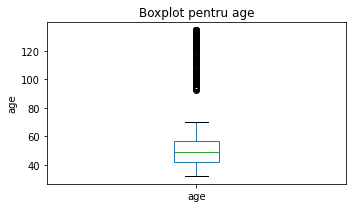

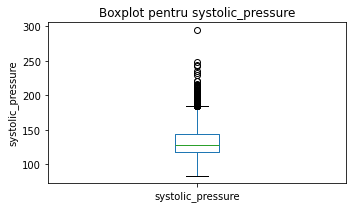

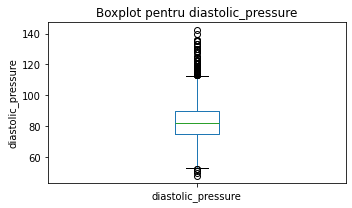

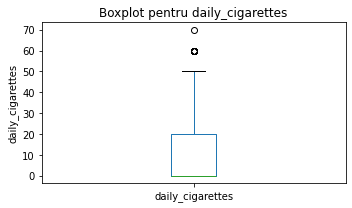

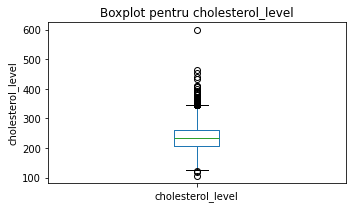

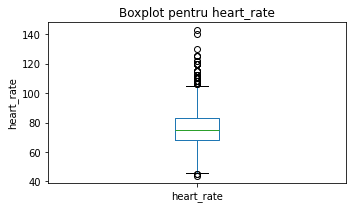

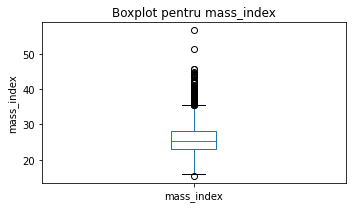

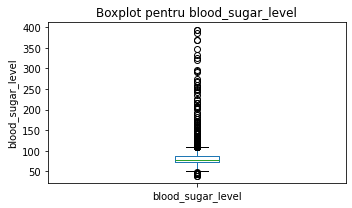

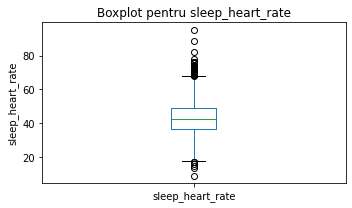

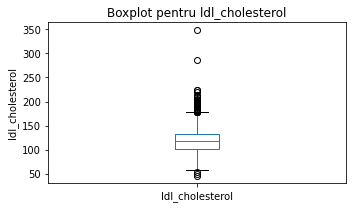

In [27]:
numeric_cols = [
    'age', 'systolic_pressure', 'diastolic_pressure', 'daily_cigarettes',
    'cholesterol_level', 'heart_rate', 'mass_index',
    'blood_sugar_level', 'sleep_heart_rate', 'ldl_cholesterol'
]

numeric_data = df[numeric_cols].describe()
print(numeric_data)

for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    df.boxplot(column=col)
    plt.title(f'Boxplot pentru {col}')
    plt.ylabel(col)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

### Analyzing discret/ordinary atributes

Number of examples with no NaN values: 3783

Number of unique values:
gender                       2
education_level              4
blood_pressure_medication    2
smoking_status               2
hypertension_history         2
stroke_history               2
diabetes_history             2
high_blood_sugar             2
dtype: int64


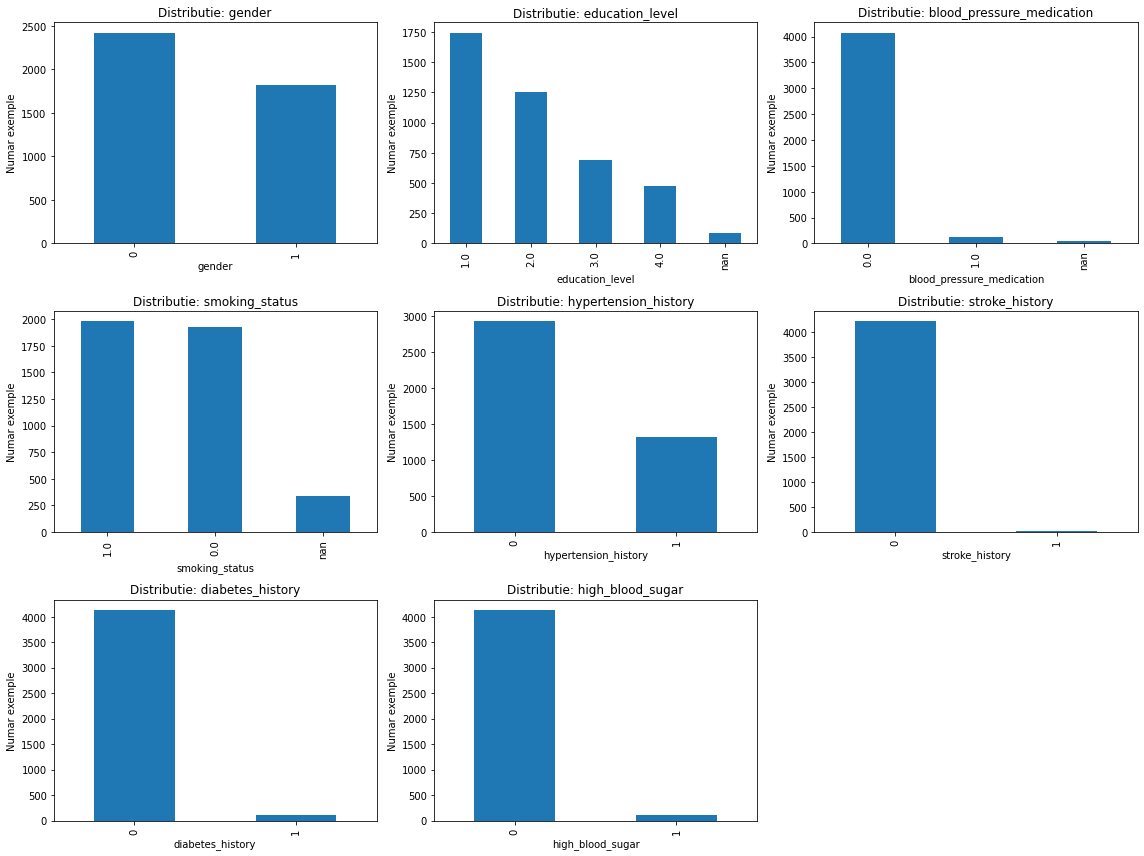

In [ ]:
import matplotlib.pyplot as plt

discret__ordinary_cols = [
    'gender', 'education_level', 'blood_pressure_medication',
    'smoking_status', 'hypertension_history', 'stroke_history',
    'diabetes_history', 'high_blood_sugar'
]

print(f"Number of examples with no NaN values: {len(df[discret__ordinary_cols].dropna())}\n")

nunique_vals = df[discret__ordinary_cols].nunique()
print(f"Number of unique values:\n{nunique_vals}")

plt.figure(figsize=(16, 12))

for idx, col in enumerate(discret__ordinary_cols):
    plt.subplot(3, 3, idx + 1)
    df[col].value_counts(dropna=False).plot(kind='bar')
    plt.title(f'Distributie: {col}')
    plt.xlabel(col)
    plt.ylabel('Numar exemple')

plt.tight_layout()
plt.show()

### Analyzing balance of classes

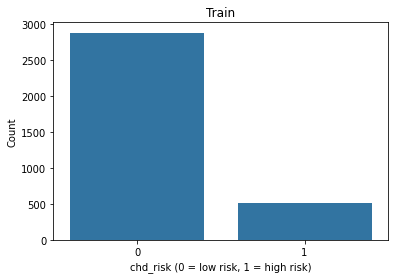

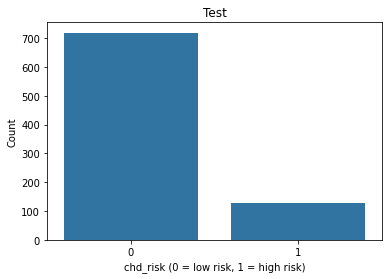

In [29]:
import seaborn as sns

sns.countplot(x='chd_risk', data=df_train)
plt.title('Train')
plt.xlabel('chd_risk (0 = low risk, 1 = high risk)')
plt.ylabel('Count')
plt.show()

sns.countplot(x='chd_risk', data=df_test)
plt.title('Test')
plt.xlabel('chd_risk (0 = low risk, 1 = high risk)')
plt.ylabel('Count')
plt.show()


### Analyzing corelation between atributes

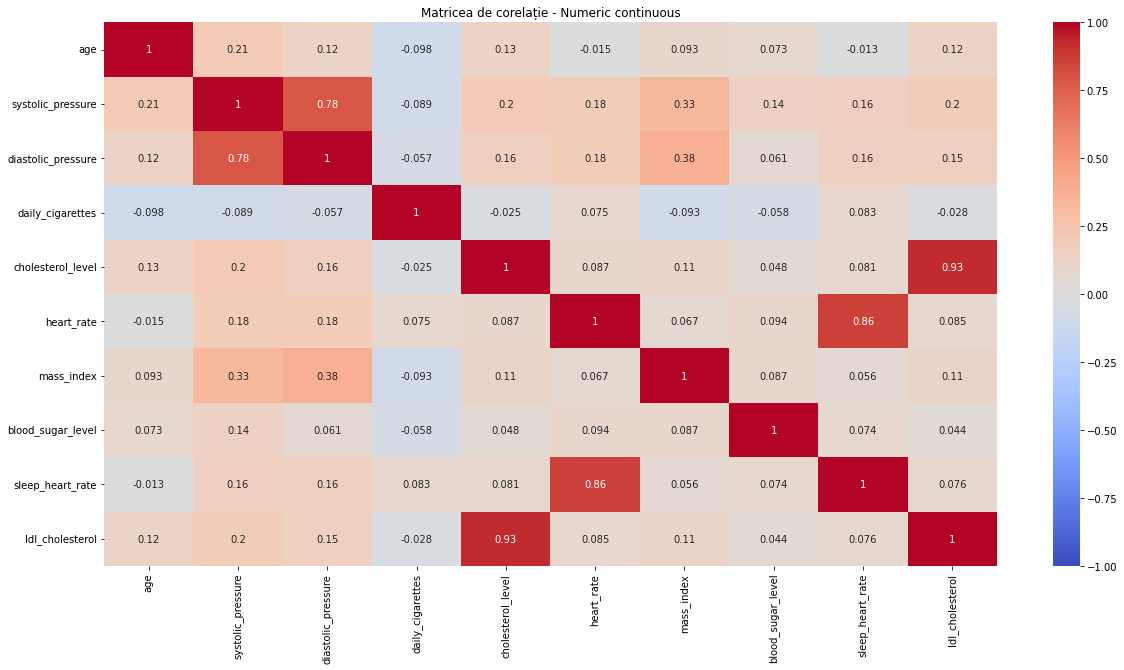

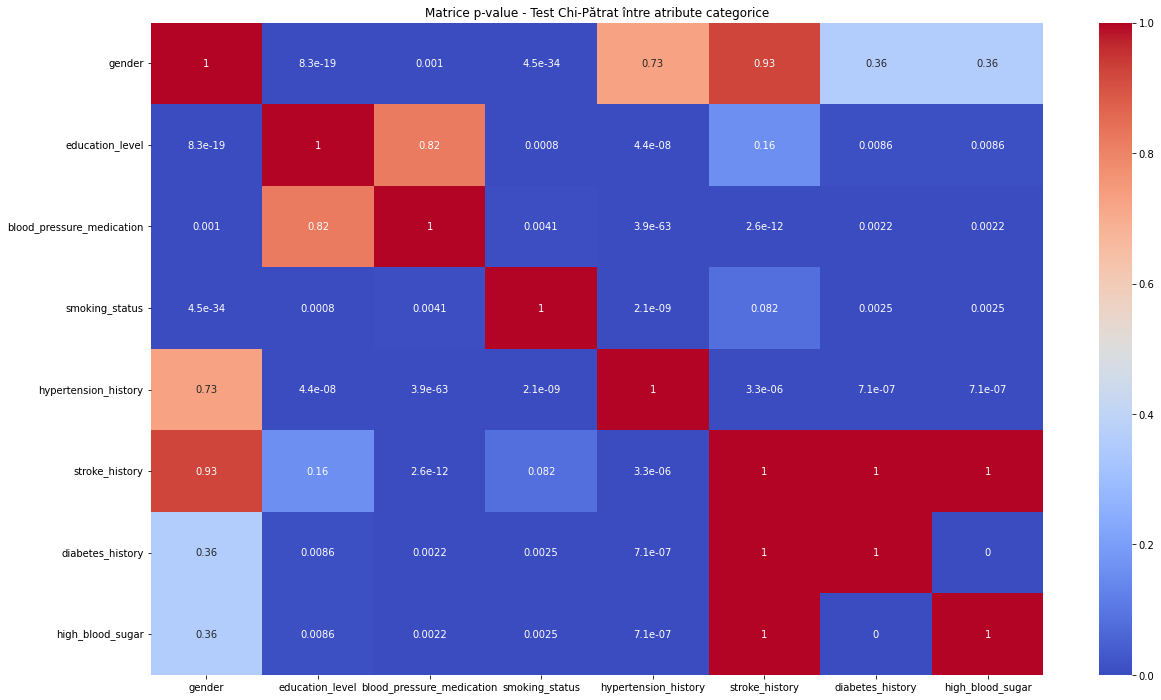

In [ ]:
# Between numerical atributes
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matricea de corelație - Numeric continuous')
plt.xticks(rotation=90)
plt.show()

# Between categorical atributes
from scipy.stats import chi2_contingency
categorical_cols = [
    'gender', 'education_level', 'blood_pressure_medication',
    'smoking_status', 'hypertension_history', 'stroke_history',
    'diabetes_history', 'high_blood_sugar'
]

pval_matrix = pd.DataFrame(np.ones((len(categorical_cols), len(categorical_cols))),
                          index=categorical_cols, columns=categorical_cols)

for i in range(len(categorical_cols)):
    for j in range(i+1, len(categorical_cols)):
        col1 = categorical_cols[i]
        col2 = categorical_cols[j]
        contingency_table = pd.crosstab(df[col1], df[col2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        pval_matrix.loc[col1, col2] = p
        pval_matrix.loc[col2, col1] = p

np.fill_diagonal(pval_matrix.values, 1)

plt.figure(figsize=(20, 12))
sns.heatmap(pval_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Matrice p-value - Test Chi-Pătrat între atribute categorice')
plt.show()

# Preprocesing

Printing atributes with missing data

In [31]:
missing_cols = df.columns[df.isna().any()]
print("Atribute cu valori lipsă:", list(missing_cols))


Atribute cu valori lipsă: ['blood_pressure_medication', 'cholesterol_level', 'daily_cigarettes', 'heart_rate', 'smoking_status', 'mass_index', 'blood_sugar_level', 'education_level', 'sleep_heart_rate', 'ldl_cholesterol']


### Imputation of missing values

In [32]:
from sklearn.impute import SimpleImputer

# For blood_pressure_medication
imputer = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)
df[['blood_pressure_medication']] = imputer.fit_transform(df[['blood_pressure_medication']])

In [33]:
# For daily_cigarettes
imputer = SimpleImputer(strategy='constant', missing_values=pd.NA, fill_value=0)
df[['daily_cigarettes']] = imputer.fit_transform(df[['daily_cigarettes']])

362


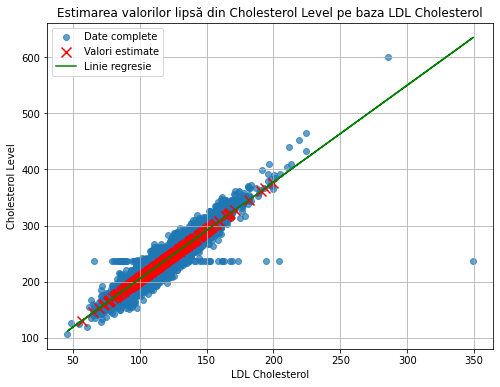

37
0


In [34]:
# For cholesterol level
from sklearn.linear_model import LinearRegression
df_nonan = df[['cholesterol_level', 'ldl_cholesterol']].dropna()

print(df['cholesterol_level'].isnull().sum())
X_train = df_nonan[['ldl_cholesterol']]
y_train = df_nonan['cholesterol_level']

# Antrenăm modelul de regresie liniară
model = LinearRegression()
model.fit(X_train, y_train)

# Găsim rândurile unde cholesterol_level lipsește, dar ldl_cholesterol există
missing_cholesterol = df['cholesterol_level'].isna() & df['ldl_cholesterol'].notna()

# Prezicem valorile lipsă
predicted_values = model.predict(df.loc[missing_cholesterol, ['ldl_cholesterol']])
df.loc[missing_cholesterol, 'cholesterol_level'] = predicted_values

# Grafic: punctele originale și cele completate
plt.figure(figsize=(8,6))
plt.scatter(df_nonan['ldl_cholesterol'], df_nonan['cholesterol_level'], label='Date complete', alpha=0.7)
plt.scatter(df.loc[missing_cholesterol, 'ldl_cholesterol'], predicted_values, color='red', label='Valori estimate', marker='x', s=100)
plt.plot(df_nonan['ldl_cholesterol'], model.predict(X_train), color='green', label='Linie regresie')
plt.xlabel('LDL Cholesterol')
plt.ylabel('Cholesterol Level')
plt.title('Estimarea valorilor lipsă din Cholesterol Level pe baza LDL Cholesterol')
plt.legend()
plt.grid(True)
plt.show()

print(df['cholesterol_level'].isnull().sum())
# completam cu mediana pe valorile care inca sunt lipsa
imputer = SimpleImputer(strategy='median', missing_values=pd.NA)
df[['cholesterol_level']] = imputer.fit_transform(df[['cholesterol_level']])
print(df['cholesterol_level'].isnull().sum())


In [35]:
# For heart rate
print(df['heart_rate'].isnull().sum())
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df[['heart_rate', 'sleep_heart_rate']] = imputer.fit_transform(df[['heart_rate', 'sleep_heart_rate']])
print(df['heart_rate'].isnull().sum())


1
0


In [36]:
# For mass_index
print(df['mass_index'].isnull().sum())

imputer = SimpleImputer(strategy='mean')
df['mass_index'] = imputer.fit_transform(df[['mass_index']])
print(df['mass_index'].isnull().sum())


18
0


In [37]:
# For blood sugar level
print(df['blood_sugar_level'].isnull().sum())

imputer = SimpleImputer(strategy='mean')
df['blood_sugar_level'] = imputer.fit_transform(df[['blood_sugar_level']])
print(df['blood_sugar_level'].isnull().sum())

321
0


### Reduntant atributes


In [38]:
df.drop(columns=['ldl_cholesterol', 'sleep_heart_rate', 'education_level', 'smoking_status'], inplace=True)
categorical_cols = [col for col in categorical_cols if col not in ['education_level', 'smoking_status']]
missing_cols = df.columns[df.isna().any()]
print("Atribute cu valori lipsă:", list(missing_cols))

Atribute cu valori lipsă: []


### remove of extreme values

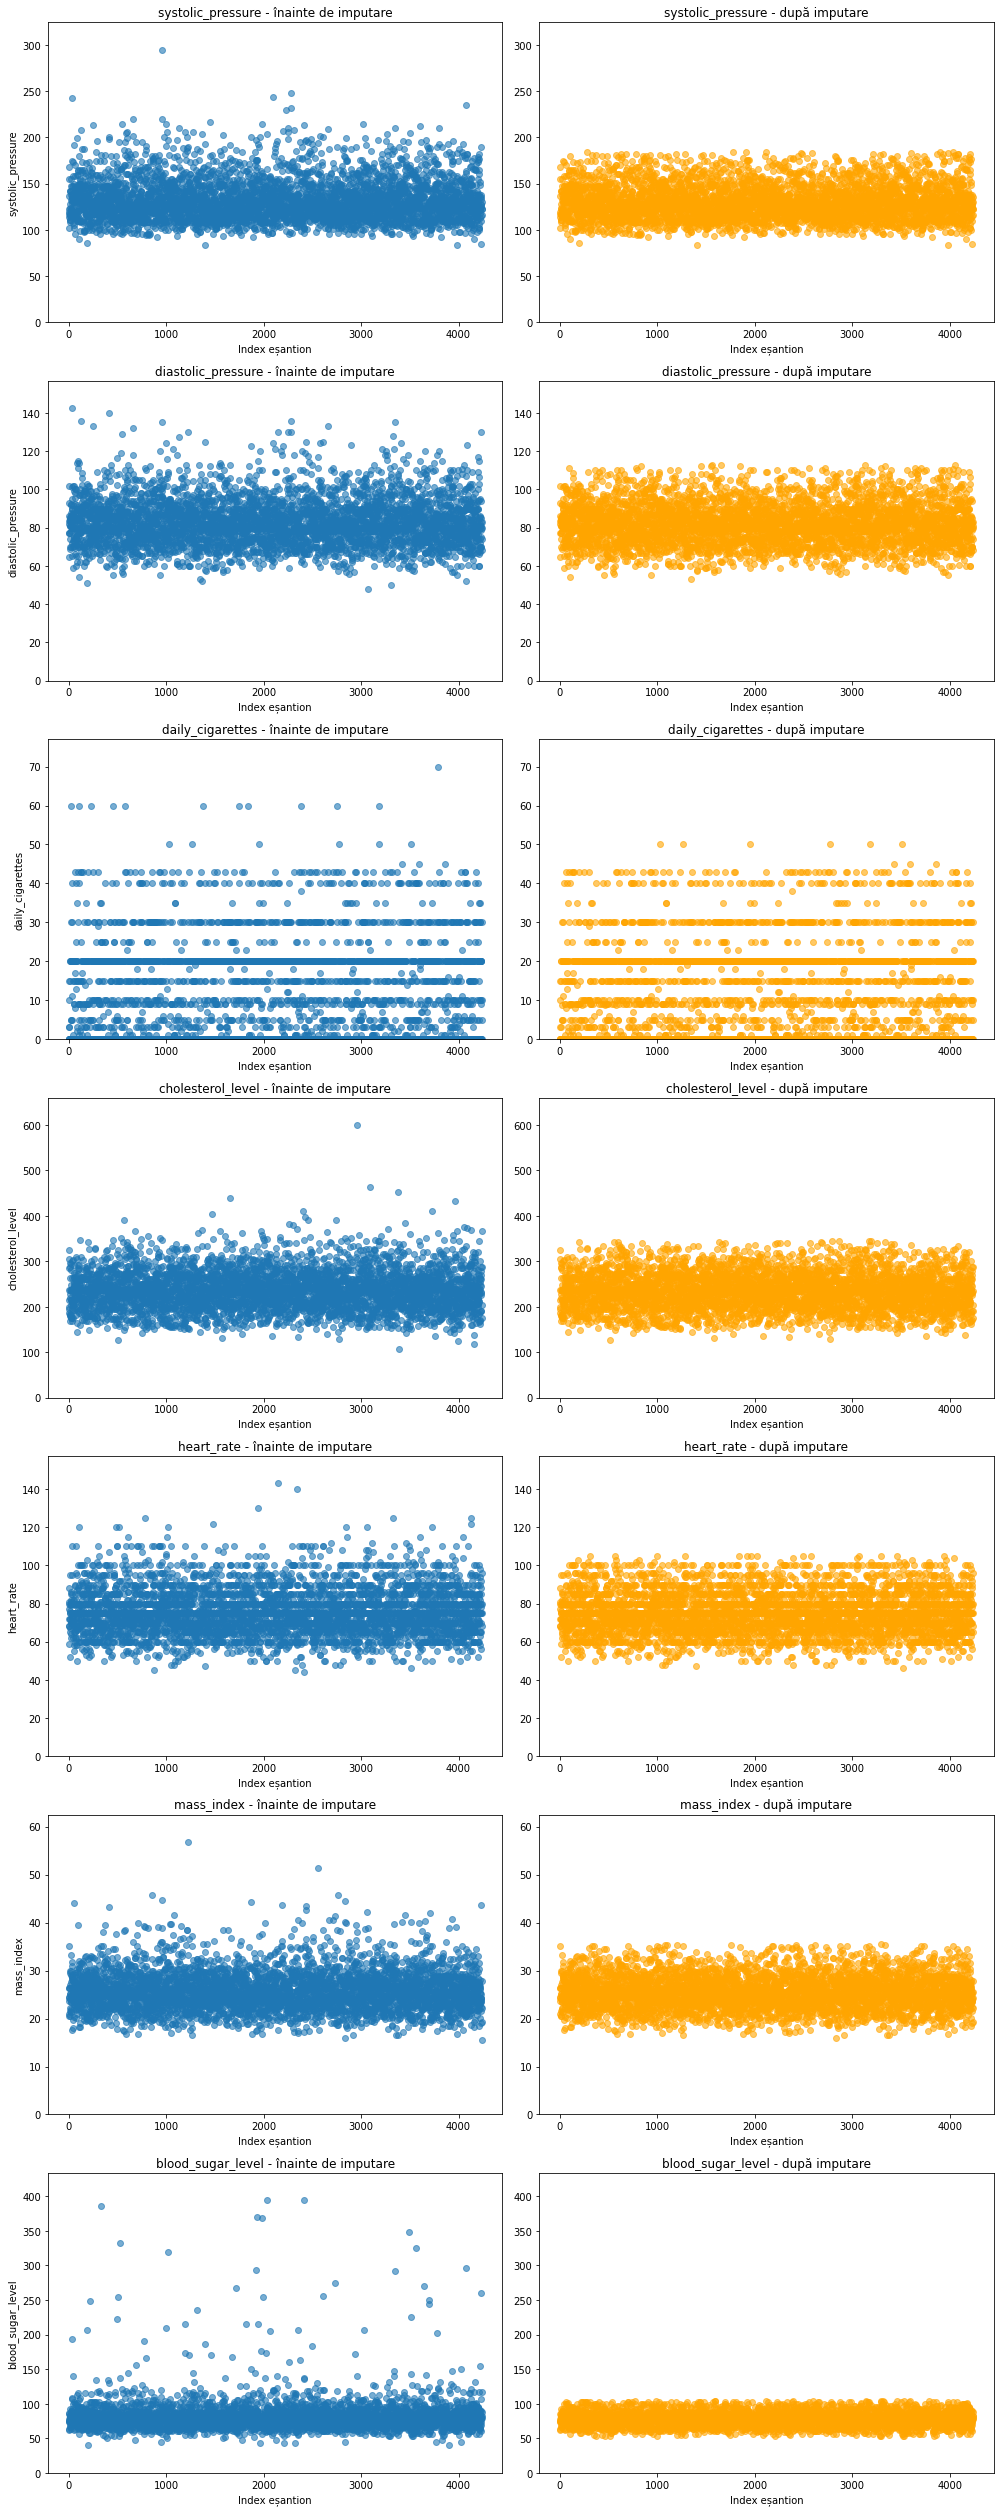

In [ ]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np

cols = ['systolic_pressure', 'diastolic_pressure', 'daily_cigarettes',
        'cholesterol_level', 'heart_rate', 'mass_index', 'blood_sugar_level']

imputer = SimpleImputer(strategy='mean')
df_copy = df[cols].copy()
plt.figure(figsize=(14, len(cols)*5))

for i, col in enumerate(cols):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    plt.subplot(len(cols), 2, 2*i + 1)
    plt.scatter(range(len(df[col])), df[col], alpha=0.6)
    plt.title(f'{col} - înainte de imputare')
    plt.xlabel('Index eșantion')
    plt.ylabel(col)
    plt.ylim(0, 1.1 * df_copy[col].max()) 
    
    # Setăm valorile extreme ca NaN în copia pentru imputare
    mask_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    df.loc[mask_outliers, col] = np.nan

    # Imputăm valorile lipsă (inclusiv extremele)
    df[col] = imputer.fit_transform(df[[col]])

    plt.subplot(len(cols), 2, 2*i + 2)
    plt.scatter(range(len(df[col])), df[col], alpha=0.6, color='orange')
    plt.title(f'{col} - după imputare')
    plt.xlabel('Index eșantion')
    plt.ylim(0, 1.1 * df_copy[col].max())

plt.tight_layout()
plt.show()


### Standardization

In [40]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['systolic_pressure', 'diastolic_pressure', 'daily_cigarettes',
                'cholesterol_level', 'heart_rate', 'mass_index', 'blood_sugar_level']

scaler = StandardScaler()

# Extragem doar coloanele numerice
X_numeric = df[numeric_cols]

# Aplicăm scalarea
X_scaled = scaler.fit_transform(X_numeric)

# Dacă vrei să păstrezi într-un DataFrame cu aceleași nume de coloane:
df[numeric_cols] = X_scaled

# Verificăm media și deviația standard după scalare
print(f'Media pe coloane după scalare:\n{df[numeric_cols].mean(axis=0)}\n')
print(f'Deviația standard pe coloane după scalare:\n{df[numeric_cols].std(axis=0)}\n')


Media pe coloane după scalare:
systolic_pressure     1.586153e-15
diastolic_pressure    2.078002e-16
daily_cigarettes     -1.173066e-17
cholesterol_level     1.625534e-16
heart_rate           -2.463438e-16
mass_index           -2.488575e-16
blood_sugar_level    -2.115708e-16
dtype: float64

Deviația standard pe coloane după scalare:
systolic_pressure     1.000118
diastolic_pressure    1.000118
daily_cigarettes      1.000118
cholesterol_level     1.000118
heart_rate            1.000118
mass_index            1.000118
blood_sugar_level     1.000118
dtype: float64



### Encoding categorical variables

In [41]:
df = pd.get_dummies(df, columns=categorical_cols, dtype=float, drop_first=False)
print(df)

      cholesterol_level  systolic_pressure  daily_cigarettes  \
0          2.300606e+00          -0.611905         -0.761283   
1          3.414921e-02          -0.882535         -0.502042   
2         -1.240430e+00           1.336634         -0.761283   
3         -5.016526e-01          -1.532048          0.102852   
4          1.791105e+00           2.040273         -0.761283   
...                 ...                ...               ...   
3387      -1.138530e+00           0.254112          0.966988   
3388      -1.520656e+00          -0.016518         -0.329215   
3389      -8.073536e-01          -0.449527         -0.761283   
3390       1.358028e+00          -0.422464          1.831123   
3391       7.240454e-16          -0.774283          0.102852   

      diastolic_pressure  heart_rate    mass_index  blood_sugar_level   age  \
0               0.350306   -0.664931  2.768296e+00          -1.509037  46.0   
1              -0.493740    0.435499 -1.287520e+00           0.688200  39

## Decision TREE

Confusion Matrix:
[[631  81]
 [109  27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       712
           1       0.25      0.20      0.22       136

    accuracy                           0.78       848
   macro avg       0.55      0.54      0.55       848
weighted avg       0.76      0.78      0.77       848


Accuracy: 0.7759


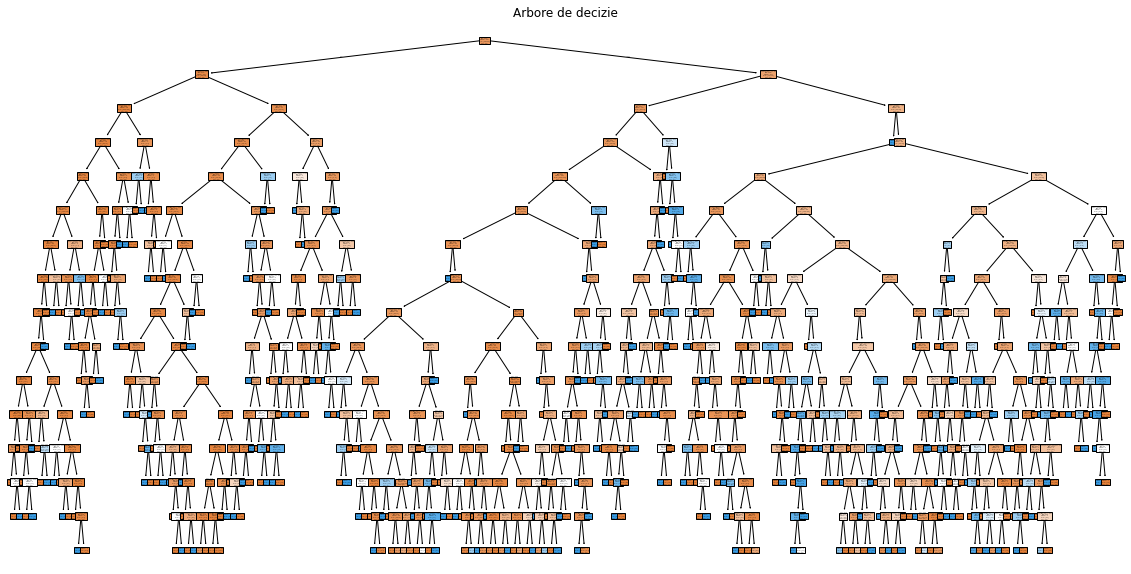

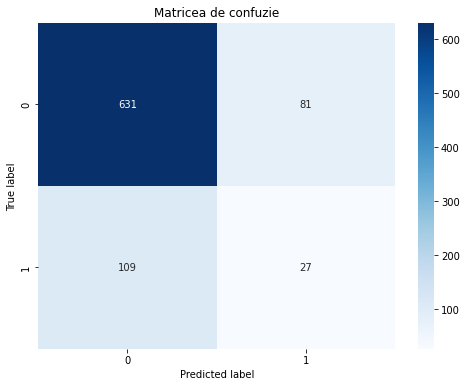

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

target_col = 'chd_risk'  # înlocuiește cu numele real

X = df.drop(columns=[target_col])  # variabilele de intrare
y = df[target_col]                 # eticheta

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = DecisionTreeClassifier(criterion='gini', max_depth= 15, min_samples_leaf=1, random_state=123)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, class_names=True, filled=True)
plt.title("Arbore de decizie")
plt.show()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Matricea de confuzie')
plt.show()


## Random Forest


Confusion Matrix:
[[715   4]
 [119  10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       719
           1       0.71      0.08      0.14       129

    accuracy                           0.85       848
   macro avg       0.79      0.54      0.53       848
weighted avg       0.84      0.85      0.80       848


Accuracy: 0.8550


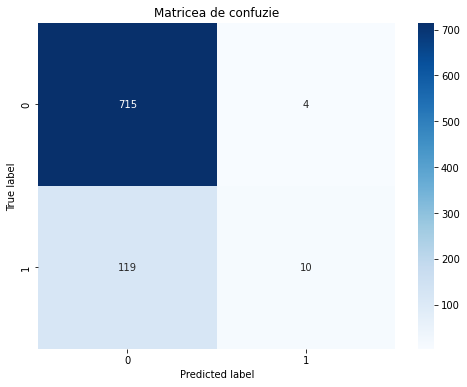

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop('chd_risk', axis=1)
y = df['chd_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)

model = RandomForestClassifier(random_state=123)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Matricea de confuzie')
plt.show()

## Multi-Layered perceptron


Confusion Matrix:
[[715   4]
 [119  10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       719
           1       0.71      0.08      0.14       129

    accuracy                           0.85       848
   macro avg       0.79      0.54      0.53       848
weighted avg       0.84      0.85      0.80       848


Accuracy: 0.8550


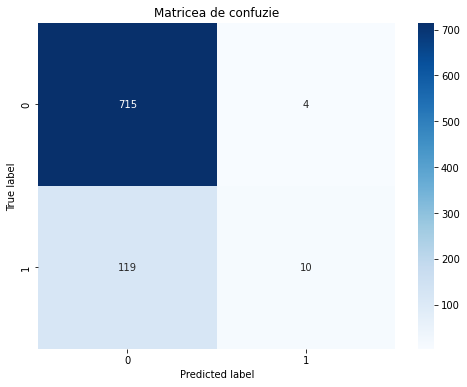

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop('chd_risk', axis=1)
y = df['chd_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)

model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=123)
model.fit(X_train, y_train)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Matricea de confuzie')
plt.show()

## Logistic Regression


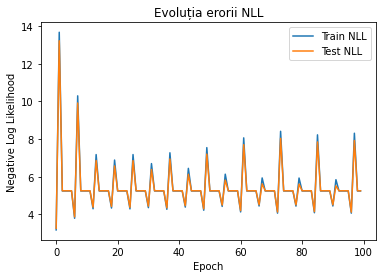

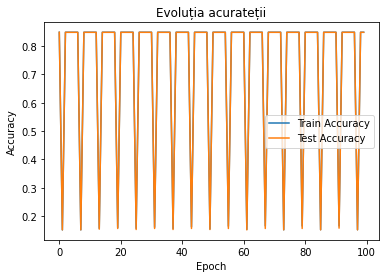

Acuratețe finală pe train: 0.8482
Acuratețe finală pe test: 0.8479


In [23]:
# TODO <1>: Implementati functia de sigmoida logistica
def logistic(x):
    eps=1e-15
    sig = 1 / (1 + np.exp(-x))
    return np.clip(sig, eps, 1 - eps) 

# TODO <2.1>: Implementati expresia pentru Negative Log Likelihood - functia J(w), unde Y este predictia data de modelul logistic, 
# iar T sunt etichetele de clasa pentru cele N exemple din setul de date
def nll(Y, T):
    N = T.shape[0]

    # TODO: Inlocuiti aici cu expresia functiei de Negative Log Likelihood
    # Hint: folositi notiunea de indexare logica din numpy si faptul ca T poate fi 0 sau 1
    return (-1 / N) * (T @ np.log(Y) + (1 - T) @ np.log(1 - Y))

# TODO <2.2>: Implementati expresia care intoarce acuratetea clasificarii
def accuracy(Y, T):
    N = Y.shape[0]

    # TODO: Inlocuiti aici cu expresia functiei de acuratete
    # Hint: folositi notiunea de indexare logica din numpy si faptul ca 
    #       in numpy True este echivalent cu 1 si False cu 0
    Y_pred = Y >= 0.5
    return np.sum(Y_pred == T) / N

def predict_logistic(X, w):
    # TODO <3.1> : Calculati predictia Y a modelului logistic antrenat (ponderile w invatate)
    # Hint: urmariti explicatiile de utilizare ale functiei `numpy.dot` pentru a putea calcula 
    # produsele scalare intre toti vectorii x^(i) si ponderile w intr-un singur apel
    N = X.shape[0]
    return logistic(X @ w)
def train_and_eval_logistic(X_train, T_train, X_test, T_test, lr=.01, epochs_no=100):
    # TODO <3.2> : Antrenati modelul logistic (ponderile W), executand epochs_no pasi din algoritmul de gradient descent
    (N, D) = X.shape
    
    # Initializare ponderi
    np.random.seed(123)
    w = np.random.randn(D)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []

    for epoch in range(epochs_no):
        # 1. Obtineti Y_train si Y_test folosind functia predict_logistic
        Y_train = predict_logistic(X_train, w)
        Y_test  = predict_logistic(X_test, w)
        # 2. Adaugati acuratetea si negative log likelihood-ul pentru setul de antrenare si de testare 
        #    la fiecare pas; utilizati functiile accuracy si nll definite anterior
        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        # 3. Actualizati ponderile w folosind regula de actualizare a gradientului
        w -= (lr / N) * np.dot(X_train.T, (Y_train - T_train))    

    return w, train_nll, test_nll, train_acc, test_acc

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# Exemplu: presupunem ca X_train, T_train, X_test, T_test sunt deja definite

# Antrenare și evaluare logistic regression
w, train_nll, test_nll, train_acc, test_acc = train_and_eval_logistic(
    X_train, y_train, X_test, y_test, lr=0.1, epochs_no=100
)


plt.plot(train_nll, label='Train NLL')
plt.plot(test_nll, label='Test NLL')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.title('Evoluția erorii NLL')
plt.show()

plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Evoluția acurateții')
plt.show()

print(f"Acuratețe finală pe train: {train_acc[-1]:.4f}")
print(f"Acuratețe finală pe test: {test_acc[-1]:.4f}")